In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from ydata_profiling import ProfileReport
import sys

sys.path.append('../')
pd.set_option('display.max_columns', None)

from config.paths import RAW_DATA_PATH, CONFIG_PATH, PROCESSED_DATA_PATH
from utils.file_management import read_yaml
from utils.processing import discretize_data, remove_price_outliers, replace_zeros_with_nans, transform_area_units

---
# Import data

Raw dataset and features configuration is imported

In [2]:
df = pd.read_csv(f'{RAW_DATA_PATH}/RealEstate_California.csv').drop(columns=["Unnamed: 0"])
features = read_yaml(f'{CONFIG_PATH}/features.yaml')
target = features['target']

In [3]:
df.head(2)

,id,stateId,countyId,cityId,country,datePostedString,is_bankOwned,is_forAuction,event,time,price,pricePerSquareFoot,city,state,yearBuilt,streetAddress,zipcode,longitude,latitude,hasBadGeocode,description,currency,livingArea,livingAreaValue,lotAreaUnits,bathrooms,bedrooms,buildingArea,parking,garageSpaces,hasGarage,levels,pool,spa,isNewConstruction,hasPetsAllowed,homeType,county
0,95717-2087851113,9,77,24895,USA,2021-01-13,0,0,Listed for sale,1.610496e+12,145000.0,0.0,Gold Run,CA,0,0 Moody Ridge Rd,95717.0,-120.834473,39.167866,0,Amazing opportunity to build your dream home O...,USD,0.0,0.0,Acres,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,LOT,Placer County
1,94564-18496265,9,189,36958,USA,2021-07-12,0,0,Listed for sale,1.626048e+12,675000.0,404.0,Pinole,CA,1958,1476 Belden Ct,94564.0,-122.300613,38.001213,0,"""Great house in a wonderful neighborhood! Wal...",USD,1671.0,1671.0,sqft,2.0,3.0,1671.0,1,2.0,1,One Story,0,0,0,0,SINGLE_FAMILY,Contra Costa County


---

# Preprocessing

* [X] Drop duplicated IDs.
* [X] Drop useless and noisy features.
* [X] Drop price == 0.
* [X] Drop price outliers.
* [X] Homologate different area units to mts2.
* [X] Normalize area feature distribution.
* [X] Discretize features with explicit nulls marked as zeros.
* [X] Create mapped features over the cardinal discretized features.
* [X] Create a function that reduces 'levels' feature cardinality.
* [X] Reduce cardinality on homeType feature.
* [X] If hasGarage==0 & garageSpaces!=0, change hasGarage value to 1

### Drop duplicated ids

In [4]:
df.sort_values(['id', 'datePostedString'])
df.drop_duplicates(subset="id", keep='first', inplace=True)

### Drop features

In [5]:
columns_to_drop = features['constant_columns'] + features['unique_columns'] + features['heavily_imbalanced_columns'] + features['non_important_columns'] + features['data_leakage_columns']
df.drop(columns=columns_to_drop, inplace=True)

In [6]:
#df.describe(percentiles=[i/20 for i in range(20)])

# Outliers treatment

In [7]:
len(df)

31238

In [8]:
df = df[df['price'] > 0]

lower_bound_price = np.percentile(df['price'], 2.5)
upper_bound_price = np.percentile(df['price'], 97.5)

df = df[df['price'].between(lower_bound_price, upper_bound_price)]

print(lower_bound_price, upper_bound_price)

29500.0 5500000.0


# Create price_log feature

In [9]:
df['price_log'] = np.log(df['price'])

# Homologate SquareFoot and Acre to mt3 and transform to log

In [10]:
df = transform_area_units(df)

# Clean outliers and recategorize

In [11]:
percentiles = [i/10 for i in range(10)]

---

count    29446.000000
mean         2.621714
std          1.945455
min          0.000000
0%           0.000000
10%          0.000000
20%          0.000000
30%          2.000000
40%          3.000000
50%          3.000000
60%          3.000000
70%          4.000000
80%          4.000000
90%          4.000000
max         99.000000
Name: bedrooms, dtype: float64

<AxesSubplot: >

3      0.310195
NaN    0.213781
4      0.207668
<=2    0.173810
>=5    0.094546
Name: bedrooms_disc, dtype: float64


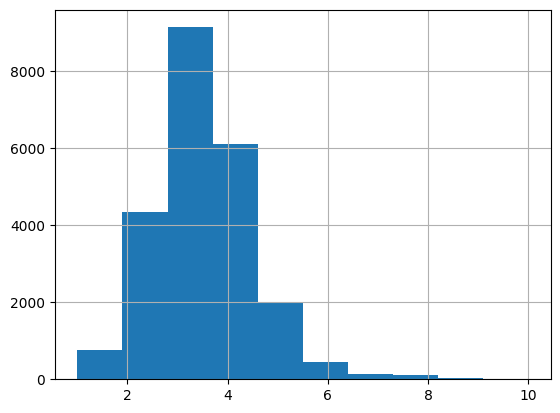

In [12]:
display(df['bedrooms'].describe(percentiles=percentiles))
display(df[df['bedrooms'].between(1,10)]['bedrooms'].hist())

bedroom_conds = [
    df['bedrooms']==0,
    df['bedrooms']>=5,
    df['bedrooms']==4,
    df['bedrooms']==3,
    df['bedrooms']<=2,
    df['bedrooms'].isna()
]

bedroom_values = ['NaN', '>=5', '4', '3', '<=2', 'NaN']

df['bedrooms_disc'] = np.select(bedroom_conds, bedroom_values)

print(df['bedrooms_disc'].value_counts(normalize=True))

count    29446.000000
mean         1.985057
std          1.543169
min          0.000000
0%           0.000000
10%          0.000000
20%          0.000000
30%          1.000000
40%          2.000000
50%          2.000000
60%          2.000000
70%          3.000000
80%          3.000000
90%          4.000000
max         48.000000
Name: bathrooms, dtype: float64

<AxesSubplot: >

2      0.310670
3      0.241697
NaN    0.229607
>=4    0.112409
1      0.105617
Name: bathrooms_disc, dtype: float64


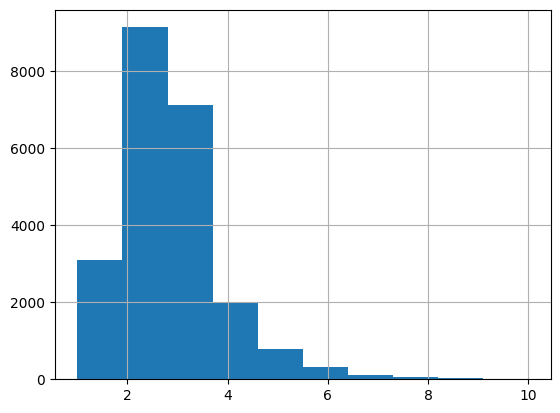

In [13]:
display(df['bathrooms'].describe(percentiles=percentiles))
display(df[df['bathrooms'].between(1,10)]['bathrooms'].hist())

bathroom_conds = [
    df['bathrooms']>=4,
    df['bathrooms']==3,
    df['bathrooms']==2,
    df['bathrooms']==1,
    df['bathrooms']==0,
    df['bathrooms'].isna()
]

bathroom_values = ['>=4', '3', '2', '1', 'NaN', 'NaN']

df['bathrooms_disc'] = np.select(bathroom_conds, bathroom_values)

print(df['bathrooms_disc'].value_counts(normalize=True))

count    24393.000000
mean      1973.102611
std         93.482050
min       1850.000000
0%        1850.000000
10%       1930.000000
20%       1950.000000
30%       1957.000000
40%       1965.000000
50%       1975.000000
60%       1982.000000
70%       1989.000000
80%       2000.000000
90%       2007.000000
max       9999.000000
Name: yearBuilt, dtype: float64

<AxesSubplot: >

1975-2000    7450
1950-1975    7075
NaN          5056
1925-1950    3511
2000-2010    2874
>2010        1753
<1925        1727
Name: yearBuilt_disc, dtype: int64


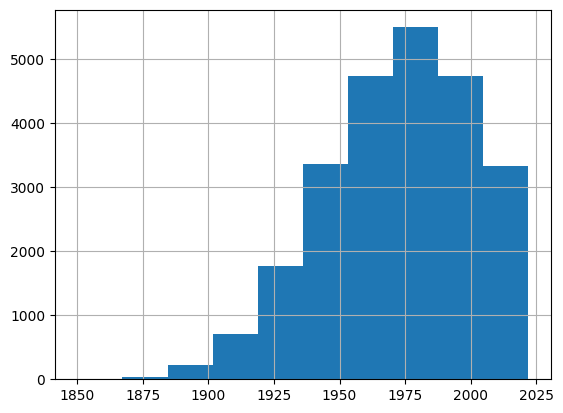

In [14]:
display(df[df['yearBuilt']!=0]['yearBuilt'].describe(percentiles=percentiles))
display(df[df['yearBuilt'].between(1800,2024)]['yearBuilt'].hist())

yearBuilt_conds = [
    df['yearBuilt']==9999,
    df['yearBuilt']==0,
    df['yearBuilt']<1925,
    df['yearBuilt']<=1950,
    df['yearBuilt']<=1975,
    df['yearBuilt']<=2000,
    df['yearBuilt']<=2010,
    df['yearBuilt']>2010,
    df['yearBuilt'].isna()
]

yearBuilt_values = ['NaN', 'NaN', '<1925', '1925-1950', '1950-1975', '1975-2000', '2000-2010', '>2010', 'NaN']

df['yearBuilt_disc'] = np.select(yearBuilt_conds, yearBuilt_values)

print(df['yearBuilt_disc'].value_counts())

df['yearBuilt'] = np.where(
    df['yearBuilt'].between(1850, 2024)==False, 
    0,
    df['yearBuilt']
    )

In [15]:
df['garageSpaces'] = np.where(
    df['garageSpaces']>4,
    4,
    df['garageSpaces']
    )

---

# Map discretized features

In [16]:
mapping_yearBuilt = {'NaN': -1, '<1925': 1, '1925-1950': 2, '1950-1975': 3, '1975-2000': 4, '2000-2010': 5, '>2010': 6}
df['mapped_yearBuilt'] = df['yearBuilt'].map(mapping_yearBuilt)

mapping_bathrooms = {'NaN': -1, '1': 1, '2': 2, '3': 3, '>=4': 4}
df['mapped_bathrooms'] = df['bathrooms'].map(mapping_bathrooms)

mapping_bedrooms = {'NaN': -1, '<=2': 1, '3': 3, '4': 4, '>=5': 5}
df['mapped_bedrooms'] = df['bedrooms'].map(mapping_bedrooms)

In [17]:
def map_levels(levels):
  """
  Maps the categories of the "levels" feature to '0', '1', '2', and '>=3'.

  Args:
    levels: An array of strings with the categories of the "levels" feature.

  Returns:
    An array of strings with the mapped categories.
  """

  mapper = {
      "0": "0",
      "One Story": "1",
      "Two Story": "2",
      "One": "1",  # Consider merging with "One Story"
      "Three Or More": ">=3",
      "Two": "2",  # Consider merging with "Two Story"
      "Multi/Split": ">=3",
      "One-Two": "1",  # Consider merging with "One" or "Two"
      "Three": ">=3",
      "Tri-Level": ">=3",
      "Three Or More-Multi/Split": ">=3",
      "Four": ">=3",
      "One Story-Three Or More": ">=3",
      "One Story-One": "1",  # Consider merging with "One Story"
      "Three or More Stories": ">=3",
      "Two-Multi/Split": ">=3",
      "Two Story-Two": "2",  # Consider merging with "Two Story"
      "Three or More Stories-Three Or More": ">=3",
      "Two Story-One": "2",  # Consider merging with "Two Story"
      "Multi/Split-Tri-Level": ">=3",
      "Other": "0",  # Keep "Other" category if desired
      "2": "2",  # Consider merging with "Two" or "Two Story"
      "Tri-Level-Two": ">=3",
      "Three or More Stories-One": ">=3",
      "Multi/Split-Three Or More": ">=3",
      "One-Multi/Split": "1",  # Consider merging with "One"
      "One-Two-Three Or More": ">=3",
      "Two Story-Three Or More": ">=3",
      "Three or More Stories-Two": ">=3",
      "One-Three Or More": ">=3",
      "1": "1",  # Consider merging with "One" or "One Story"
      "3": ">=3",
      "Multi/Split-One": "1",  # Consider merging with "One"
      "Five or More": ">=3",
      "Split Level": ">=3",
      "One-Two-Multi/Split": ">=3",
      "Three Or More-Split Level": ">=3",
      "Multi/Split-Two": ">=3",
      "Other-One": "1",  # Keep "Other" category if desired
      "Two-Three Or More": ">=3",
      "One Story-Two": "2",  # Consider merging with "Two Story"
      "4+": ">=3",
      "Tri-Level-Three Or More": ">=3",
      "Multi-Level": ">=3",
      "Three Or More-Two": ">=3",
      "Three or More Stories-One-Two": ">=3",
      "Two-Three Or More-Multi/Split": ">=3",
      "Two-One": "2",  # Consider merging with "Two" or "Two Story"
  }

  return [mapper.get(level, level) for level in levels]

In [18]:
df['mapped_levels'] = map_levels(df['levels'])

mapping_levels = {'0': 0, '1': 1, '2': 2, '>=3': 3}
df['mapped_levels'] = df['mapped_levels'].map(mapping_levels)

In [19]:
df['homeType'] = np.where(df['homeType']=='APARTMENT', 'TOWNHOUSE', df['homeType'])

# Impute hasGarage

In [20]:
df['hasGarage'] = np.where(
    (df['hasGarage']==0) & (df['garageSpaces']!=0),
    1,
    df['garageSpaces']
    )

# Save the dataset

In [21]:
df.to_parquet(f'{PROCESSED_DATA_PATH}/preprocessed_dataset.parquet', index=False)